In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
path = os.path.abspath('gdrive/My Drive/DNST')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D,GlobalAveragePooling2D
from tensorflow.keras.layers import Input, Flatten, Dropout
from tensorflow.keras.layers import concatenate, Activation
from tensorflow.keras.optimizers import SGD
from keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
import os
import numpy as np

In [0]:
batch_size = 32
epochs = 35
data_augmentation = True

# network parameters
num_classes = 10
num_dense_blocks = 3
use_max_pool = True
growth_rate = 12
depth = 100

num_bottleneck_layers = (depth - 4) // (2 * num_dense_blocks)
print(num_bottleneck_layers)

num_filters_bef_dense_block = 2 * growth_rate
compression_factor = 0.5

16


In [0]:
# load the CIFAR10 data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [0]:
# input image dimensions
input_shape = x_train.shape[1:]
print(input_shape)

(32, 32, 3)


In [0]:
# mormalize data
data = x_train
x_train = x_train.astype('float32') 
x_test = x_test.astype('float32') 
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)


x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


normalization using Z score


In [0]:
#with mean and std normalization
# mean-std normalization
mean = np.mean(x_train,axis=(0,1,2,3))
print("mean",mean)
std = np.std(x_train,axis=(0,1,2,3))
print("std",std)
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)
 


mean 120.70748
std 64.150024


In [0]:
# convert class vectors to binary class matrices.
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [0]:
def lr_schedule(epoch):
    """Learning Rate Schedule
    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.
    # Arguments
        epoch (int): The number of epochs
    # Returns
        lr (float32): learning rate
    """
    if 0 <= epoch <=5:
      lr = 0.1
      print (lr,epoch)
      return lr
    elif 5<= epoch <=15:
      lr = 0.01
      print (lr,epoch)
      return lr
    elif 15<= epoch <=50:
      lr = 0.001
      print (lr,epoch)
      return lr
    elif 51<= epoch <=65:
      lr = 0.0005
      print (lr,epoch)
      return lr 
    elif 66<= epoch <=80:
      lr = 0.0003
      print (lr,epoch)
      return lr
    elif 81<= epoch <=95:
      lr = 0.0001
      print (lr,epoch)
      return lr
    else:
      lr = 0.00001
      print (lr,epoch)
      return lr







    #lr = 0.1
    #if epoch > 180:
        ##lr *= 0.5e-3
    #elif epoch > 160:
        #lr *= 1e-3
    #elif epoch > 120:
        #lr *= 1e-2
    #elif epoch > 80:
        #lr *= 1e-1
    #print('Learning rate: ', lr)
    #return lr

In [0]:
# start model definition
# densenet CNNs (composite function) are made of BN-ReLU-Conv2D
inputs = Input(shape=input_shape)
x = BatchNormalization()(inputs)
x = Activation('relu')(x)
x = Conv2D(num_filters_bef_dense_block,
           kernel_size=3,
           padding='same',
           kernel_initializer='he_normal')(x)
x = concatenate([inputs, x])

In [0]:

# stack of dense blocks bridged by transition layers
for i in range(num_dense_blocks):
    # a dense block is a stack of bottleneck layers
    for j in range(num_bottleneck_layers):
        y = BatchNormalization()(x)
        y = Activation('relu')(y)
        y = Conv2D(4 * growth_rate,
                   kernel_size=1,
                   padding='same',
                   kernel_initializer='he_normal')(y)
        if not data_augmentation:
            y = Dropout(0.2)(y)
        y = BatchNormalization()(y)
        y = Activation('relu')(y)
        y = Conv2D(growth_rate,
                   kernel_size=3,
                   padding='same',
                   kernel_initializer='he_normal')(y)
        if not data_augmentation:
            y = Dropout(0.2)(y)
        x = concatenate([x, y])

    # no transition layer after the last dense block
    if i == num_dense_blocks - 1:
        continue

    # transition layer compresses num of feature maps and reduces the size by 2
    num_filters_bef_dense_block += num_bottleneck_layers * growth_rate
    num_filters_bef_dense_block = int(num_filters_bef_dense_block * compression_factor)
    y = BatchNormalization()(x)
    y = Conv2D(num_filters_bef_dense_block,
               kernel_size=1,
               padding='same',
               kernel_initializer='he_normal')(y)
    if not data_augmentation:
        y = Dropout(0.2)(y)
    x = AveragePooling2D()(y)


# add classifier on top
# after average pooling, size of feature map is 1 x 1
x = GlobalAveragePooling2D()(x)
y = Flatten()(x)
outputs = Dense(num_classes,
                kernel_initializer='he_normal',
                activation='softmax')(y)

# instantiate and compile model
# orig paper uses SGD but RMSprop works better for DenseNet
model = Model(inputs=inputs, outputs=outputs)
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=0.1,decay=1e-6,nesterov=True,momentum=0.9),
              metrics=['accuracy'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
batch_normalization_198 (BatchN (None, 32, 32, 3)    12          input_3[0][0]                    
__________________________________________________________________________________________________
activation_194 (Activation)     (None, 32, 32, 3)    0           batch_normalization_198[0][0]    
__________________________________________________________________________________________________
conv2d_198 (Conv2D)             (None, 32, 32, 24)   672         activation_194[0][0]             
____________________________________________________________________________________________

In [0]:
# prepare model model saving directory
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_densenet_model.{epoch:02d}.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)


In [0]:
# prepare callbacks for model saving and for learning rate reducer
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

# run training, with or without data augmentation
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # preprocessing  and realtime data augmentation
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (deg 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

    # compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied)
    datagen.fit(x_train)

    # fit the model on the batches generated by datagen.flow()
    model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        steps_per_epoch=x_train.shape[0] // batch_size,
                        validation_data=(x_test, y_test),
                        epochs=epochs, verbose=1,
                        callbacks=callbacks)

# score trained model
scores = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

1562/1562 [==============================] - ETA: 0s - loss: 0.7287 - accuracy: 0.7507
Epoch 00005: val_accuracy improved from 0.68310 to 0.68500, saving model to /content/saved_models/cifar10_densenet_model.05.h5

Epoch 00005: val_accuracy improved from 0.68310 to 0.68500, saving model to /content/saved_models/cifar10_densenet_model.05.h5
1562/1562 [==============================] - 226s 145ms/step - loss: 0.7287 - accuracy: 0.7507 - val_loss: 1.0899 - val_accuracy: 0.6850 - lr: 0.1000
0.1 5
Epoch 6/35
   1/1562 [..............................] - ETA: 0s - loss: 0.9336 - accuracy: 0.68750.1 5
Epoch 6/35
1562/1562 [==============================] - ETA: 0s - loss: 0.6657 - accuracy: 0.7716
Epoch 00006: val_accuracy improved from 0.68500 to 0.75150, saving model to /content/saved_models/cifar10_densenet_model.06.h5

Epoch 00006: val_accuracy improved from 0.68500 to 0.75150, saving model to /content/saved_models/cifar10_densenet_model.06.h5
1562/1562 [==============================] - 2

EDA for recognizing images wrongly classified

In [0]:
li= {0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [0]:
from tqdm import tqdm
train_array = []
a = tqdm(zip(x_train , y_train))
i=0
for img , label in a:
  img_ex = np.expand_dims(img,axis=0)
  if np.argmax(model.predict(img_ex)) != np.argmax(label):
    train_array.append((img,label))
  
len(train_array)

50000it [23:46, 35.04it/s]


4029

In [0]:
from tqdm import tqdm
test_array = []
a = tqdm(zip(x_test , y_test))
for img , label in a:
  img_ex = np.expand_dims(img,axis=0)
  p= np.argmax(model.predict(img_ex))
  if p != np.argmax(label):
    test_array.append((img,label ,p ))
len(test_array)

10000it [04:46, 34.95it/s]


1244

In [0]:
s = [(x,li[np.argmax(y)] , li[z])for x , y ,z in test_array]

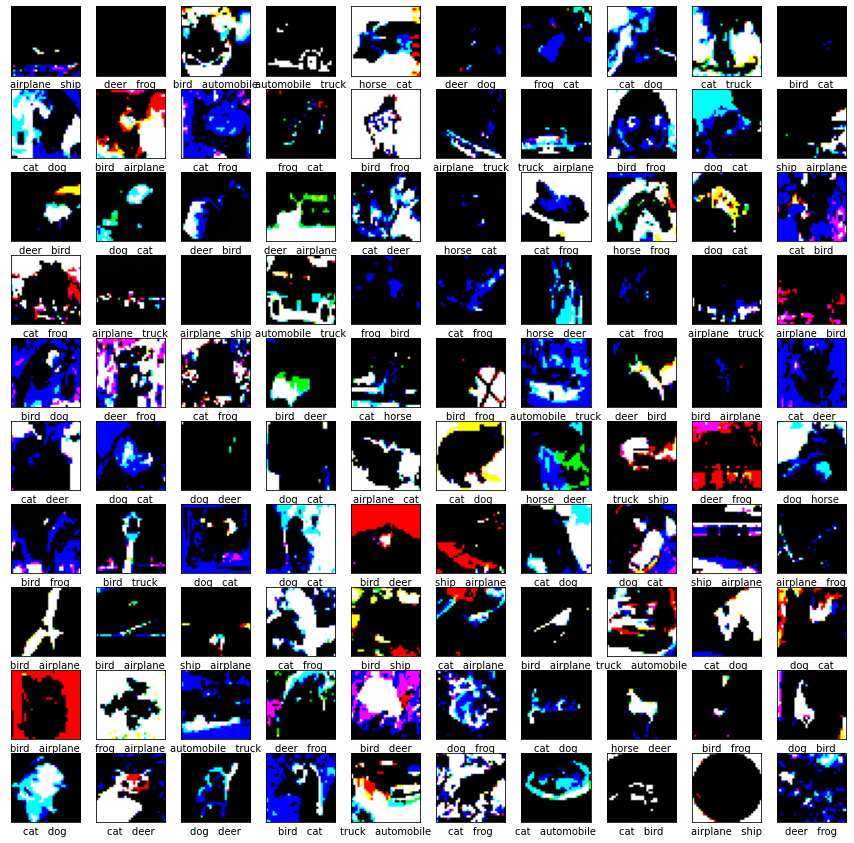

In [0]:
import matplotlib.pyplot as plt

from IPython import display
def visualize(data):
    no_of_images=len(data)
    fig = plt.figure(figsize=(15,15))
    for i in range(no_of_images):
        ax=fig.add_subplot(10,10,i+1)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.grid(False)
        ax.imshow(data[i][0].astype(np.uint8))
        ax.set_xlabel(f"{data[i][1]}   {data[i][2]}")
    plt.show()
visualize( data=s[0:100])

In [0]:
import pandas as pd
s_d = [(y,z) for x ,y,z in s]
df = pd.DataFrame(s_d)

In [0]:
gr = df.groupby([0,1])

In [0]:
filepath = "C:\\Users\\R swetha\\Desktop\\DEEP LEARNING\\end term"

ERROR! Session/line number was not unique in database. History logging moved to new session 59


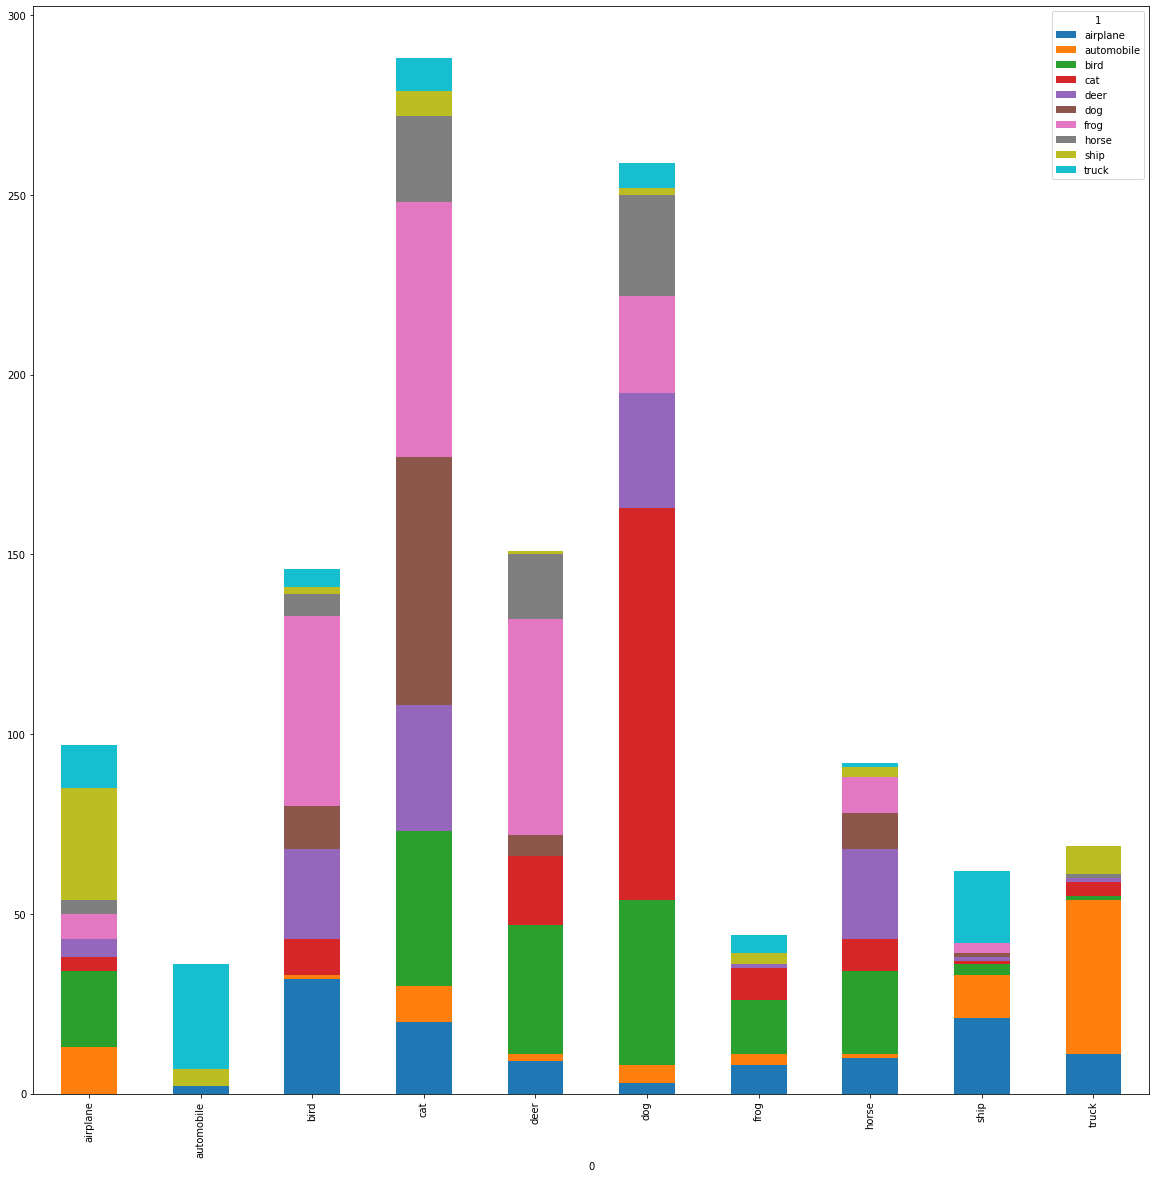

In [0]:

gr.apply(len).unstack().plot(kind='bar', stacked=True, figsize=(20,20)).get_figure().savefig(str(filePath)+"\\cifar.png",dpi ='figure',quality=100)